In [1]:
# Necessary imports
from tabulate import tabulate
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import timm
import torchvision.transforms as transforms
import pandas as pd
from PIL import Image
import numpy as np
from sklearn.metrics import classification_report
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\hecan\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Constants
# Normalize yok
# Augmentation var
BATCH_SIZE = 16
LR_RATE = 0.001
MODEL_NAME = 'vit_small_patch32_224.augreg_in21k_ft_in1k'
THRESHOLD = 0
NUM_LABELS = 20 #########

In [4]:
# Model
class SiameseModel(nn.Module):
    def __init__(self, timm_model_name):
        super(SiameseModel, self).__init__()
        model = timm.create_model(timm_model_name, pretrained=True)
        self.cnn_model = timm.create_model(timm_model_name, pretrained=True)

        for param in self.cnn_model.parameters(): # Freeze all the layers of the backbone
            param.requires_grad = False

        self.num_features = self.cnn_model.num_features  # Extract number of features from the model
        self.cnn_model.reset_classifier(num_classes=0)  # Remove the final classifier layer
        
        self.D1 = nn.Linear(self.num_features, 512)
        self.LN_1 = nn.LayerNorm(512)
        self.D2 = nn.Linear(512, 128)
        self.LN_2 = nn.LayerNorm(128)
        self.out = nn.Linear(128, NUM_LABELS)  # Output 1000-long boolean vector
    
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        
        x = self.D1(x)
        x = self.LN_1(x)
        x = nn.functional.leaky_relu(x)
        
        x = self.D2(x)
        x = self.LN_2(x)
        x = nn.functional.leaky_relu(x)
        
        out = self.out(x)
        
        return out


In [5]:
# Dataset class for image and 1000 length attribute vector.
class ImageAttributeDataset(Dataset):
    def __init__(self, dataframe, base_path, transform=None):
        self.dataframe = dataframe
        self.base_path = base_path
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['image_name']
        img_path = self.base_path + img_name  # Concatenate base path with image name
        attribute_vector = self.dataframe.iloc[idx][1:].values.astype('float64')
        
        # Load image from file
        img = Image.open(img_path).convert('RGB')
        
        # Apply transformations if specified
        if self.transform:
            img = self.transform(img)
        
        # Convert attribute vector to tensor
        attribute_tensor = torch.tensor(attribute_vector, dtype=torch.float32)
        attribute_tensor = attribute_tensor.type(torch.LongTensor)
        
        return img, attribute_tensor

In [6]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, saturation=0.5),
    transforms.ToTensor()
])

In [7]:
# Multilabel conf matrix
def metrics_df(data):
    df = pd.DataFrame(columns=["type", "precision", "recall", 'f1-score', 'support'])
    metrics = ['micro avg', 'macro avg', 'samples avg', 'weighted avg']

    for metric in metrics:
        precision = data[metric]['precision']
        recall = data[metric]['recall']
        f1_score = data[metric]['f1-score']
        support = data[metric]['support']

        df.loc[-1] = [metric, "%.5f" %precision, "%.5f" %recall, "%.5f" %f1_score, "%d" %support]  # adding a row
        df.index = df.index + 1  # shifting index
        df = df.sort_index()  # sorting by index
    
    df_no = df.reset_index(drop=True)

    print(tabulate(df_no, headers='keys', tablefmt='psql', showindex=False))

    return df

In [8]:
# Exact Paths
PATH_ATTR_FILE = "C:/Users/hecan/Desktop/Project/Benchmark/Anno/list_attr_img.txt"
PATH_PART_FILE = "C:/Users/hecan/Desktop/Project/Benchmark/Eval/list_eval_partition.txt"
BASE_PATH = "C:/Users/hecan/Desktop/Project/Benchmark/"
DATAFRAME_PATH = BASE_PATH + "dataframe.csv"

In [9]:
all_df = pd.read_csv('dataframe.csv')
all_df.head()

,image_name,evaluation_status,attr_0,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,...,attr_990,attr_991,attr_992,attr_993,attr_994,attr_995,attr_996,attr_997,attr_998,attr_999
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,val,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,test,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Top x most used class filter
def filter_data(all_df, r):
    # Extract the `attr` columns
    attr_columns = [col for col in all_df.columns if col.startswith('attr_')]
    attr_df = all_df[attr_columns]

    # Convert to numpy array
    attr_array = attr_df.values

    # Calculate class frequencies
    class_counts = np.sum(attr_array, axis=0)

    threshold = np.percentile(class_counts, r)
    attr_100_list = list()
    class_counts_x = list()

    for i in range(len(class_counts)):
        if class_counts[i] >= threshold:
            attr_100_list.append(f"attr_{i}")
            class_counts_x.append(class_counts[i])

    cols = ["image_name", "evaluation_status"]
    cols.extend(attr_100_list)
    filtered_df = all_df[cols]
    return filtered_df, attr_100_list, class_counts_x

filtered_df, attr_100_list, class_counts = filter_data(all_df, 98)

In [11]:
# Dataset Prepare
train_df_und = filtered_df[filtered_df['evaluation_status'] == 'train']
test_df_und = filtered_df[filtered_df['evaluation_status'] == 'test']
val_df_und = filtered_df[filtered_df['evaluation_status'] == 'val']

train_df = train_df_und.drop(columns=['evaluation_status'])
test_df = test_df_und.drop(columns=['evaluation_status'])
val_df = val_df_und.drop(columns=['evaluation_status'])

print("Length of test_df: ", len(test_df)) #40k test, rest train
print("Length of train_df: ", len(train_df)) #40k test, rest train
print("Length of val_df: ", len(val_df)) #40k test, rest train

train_dataset = ImageAttributeDataset(dataframe=train_df, base_path=BASE_PATH, transform=train_transform)
test_dataset = ImageAttributeDataset(dataframe=test_df, base_path=BASE_PATH, transform=transform)
val_dataset = ImageAttributeDataset(dataframe=val_df, base_path=BASE_PATH, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Length of test_df:  40000
Length of train_df:  209222
Length of val_df:  40000


In [12]:
# Extract the `attr` columns
attr_columns = [col for col in filtered_df.columns if col.startswith('attr_')]
attr_df = filtered_df[attr_columns]

# Convert to numpy array
attr_array = attr_df.values

# Calculate class frequencies
class_counts = np.sum(attr_array, axis=0)

In [13]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, logits, targets):
        logits = logits.view(-1)
        targets = targets.view(-1)
        probs = torch.sigmoid(logits)
        probs = torch.where(targets >= 0.5, probs, 1 - probs)
        log_probs = -torch.log(torch.clamp(probs, 1e-4, 1 - 1e-4))
        loss = log_probs * ((1 - probs) ** self.gamma)
        return NUM_LABELS*loss.mean()

In [14]:
# Load model
model = SiameseModel(timm_model_name=MODEL_NAME)
model.load_state_dict(torch.load('focal_loss_v2.pt')).to(device) # to remove

# Assuming optimizer is your optimizer (e.g., Adam)
optimizer = torch.optim.Adam(model.parameters(), lr=LR_RATE)

# Define the loss function with class weights
criterion = FocalLoss()

In [13]:
x1 = train_dataset[217][0].unsqueeze(0)
y1 = train_dataset[217][1].unsqueeze(0)
y1

tensor([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [14]:
x1.shape, y1.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1, 20]))

In [15]:
logits = model(x1)
logits

tensor([[-0.3097,  0.4958,  0.3076, -0.2791, -0.4870,  0.1124,  0.1391, -0.1276,
          0.4415, -0.2493,  0.0764,  0.6369, -0.8751,  0.7061, -0.5996, -0.5721,
         -0.7564,  0.1939,  0.2591,  0.3942]], grad_fn=<AddmmBackward0>)

In [16]:
logits = logits.reshape(-1)
y1 = y1.reshape(-1)

In [17]:
p = torch.sigmoid(logits)
p

tensor([0.4232, 0.6215, 0.5763, 0.4307, 0.3806, 0.5281, 0.5347, 0.4681, 0.6086,
        0.4380, 0.5191, 0.6541, 0.2942, 0.6695, 0.3544, 0.3607, 0.3194, 0.5483,
        0.5644, 0.5973], grad_fn=<SigmoidBackward0>)

In [18]:
# Training loop with validation
num_epochs = 10
model.to(device)

# Initialize lists to store true labels and predicted labels for the entire validation set
train_losses = []
val_losses = []

for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0

    print(f"Epoch {epoch+1}/{num_epochs}")

    # Training phase
    with tqdm(train_loader, unit="batch") as t:
        for batch_idx, (images, attributes) in enumerate(t):
            images, attributes = images.to(device), attributes.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, attributes.float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * attributes.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0

    # Initialize lists to store true labels and predicted labels for the entire validation set
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images_val, attributes_val in val_loader:
            images_val, attributes_val = images_val.to(device), attributes_val.to(device)
            val_outputs = model(images_val)
            loss = criterion(val_outputs, attributes_val.float())
            val_loss += loss.item() * attributes_val.size(0)
            
            # Convert outputs to binary predictions using a threshold (e.g., 0.5)
            predicted = val_outputs > THRESHOLD
            
            # Convert tensors to numpy arrays
            attributes_val_np = attributes_val.cpu().numpy()
            predicted_np = predicted.cpu().numpy()
            
            # Append true labels and predicted labels to the lists
            true_labels.extend(attributes_val_np)
            predicted_labels.extend(predicted_np)
    
    val_loss /= len(val_loader.dataset)

    val_losses.append(val_loss)
    
    # Compute confusion matrix
    print(f"Training loss: {loss.item():.4f}", f"Validation loss: {val_loss:.4f}")
    d = classification_report(true_labels, predicted_labels, target_names=attr_100_list, output_dict=True, zero_division=1)
    df_metrics = metrics_df(d)


print("Training complete!")

Epoch 1/10


  0%|          | 0/13077 [00:00<?, ?batch/s]c:\Users\hecan\AppData\Local\Programs\Python\Python311\Lib\site-packages\timm\models\vision_transformer.py:91: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  x = F.scaled_dot_product_attention(
100%|██████████| 13077/13077 [20:54<00:00, 10.42batch/s]


Training loss: 0.5931 Validation loss: 0.7473
+--------------+-------------+----------+------------+-----------+
| type         |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| weighted avg |     0.65289 |  0.17362 |    0.22446 |     36389 |
| samples avg  |     0.91212 |  0.51761 |    0.48462 |     36389 |
| macro avg    |     0.70173 |  0.12612 |    0.16778 |     36389 |
| micro avg    |     0.60051 |  0.17362 |    0.26937 |     36389 |
+--------------+-------------+----------+------------+-----------+
Epoch 2/10


100%|██████████| 13077/13077 [19:09<00:00, 11.38batch/s]


Training loss: 0.5947 Validation loss: 0.7358
+--------------+-------------+----------+------------+-----------+
| type         |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| weighted avg |     0.63108 |  0.18646 |    0.24401 |     36389 |
| samples avg  |     0.91094 |  0.5247  |    0.49103 |     36389 |
| macro avg    |     0.66336 |  0.14184 |    0.19181 |     36389 |
| micro avg    |     0.60694 |  0.18646 |    0.28528 |     36389 |
+--------------+-------------+----------+------------+-----------+
Epoch 3/10


100%|██████████| 13077/13077 [19:13<00:00, 11.34batch/s]


Training loss: 0.5497 Validation loss: 0.7339
+--------------+-------------+----------+------------+-----------+
| type         |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| weighted avg |     0.63081 |  0.15736 |    0.21721 |     36389 |
| samples avg  |     0.93206 |  0.50874 |    0.48615 |     36389 |
| macro avg    |     0.64996 |  0.12367 |    0.17402 |     36389 |
| micro avg    |     0.64243 |  0.15736 |    0.25279 |     36389 |
+--------------+-------------+----------+------------+-----------+
Epoch 4/10


100%|██████████| 13077/13077 [19:20<00:00, 11.27batch/s]


Training loss: 0.5800 Validation loss: 0.7345
+--------------+-------------+----------+------------+-----------+
| type         |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| weighted avg |     0.5888  |  0.19072 |    0.24441 |     36389 |
| samples avg  |     0.90954 |  0.52631 |    0.48924 |     36389 |
| macro avg    |     0.58861 |  0.13251 |    0.18217 |     36389 |
| micro avg    |     0.60301 |  0.19072 |    0.28978 |     36389 |
+--------------+-------------+----------+------------+-----------+
Epoch 5/10


100%|██████████| 13077/13077 [19:16<00:00, 11.31batch/s]


Training loss: 0.5830 Validation loss: 0.7284
+--------------+-------------+----------+------------+-----------+
| type         |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| weighted avg |     0.58539 |  0.19445 |    0.25887 |     36389 |
| samples avg  |     0.90851 |  0.52958 |    0.49581 |     36389 |
| macro avg    |     0.58714 |  0.15393 |    0.20899 |     36389 |
| micro avg    |     0.61632 |  0.19445 |    0.29563 |     36389 |
+--------------+-------------+----------+------------+-----------+
Epoch 6/10


100%|██████████| 13077/13077 [19:20<00:00, 11.27batch/s]


Training loss: 0.5571 Validation loss: 0.7258
+--------------+-------------+----------+------------+-----------+
| type         |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| weighted avg |     0.58604 |  0.18896 |    0.25533 |     36389 |
| samples avg  |     0.91627 |  0.52471 |    0.49491 |     36389 |
| macro avg    |     0.57994 |  0.14783 |    0.20587 |     36389 |
| micro avg    |     0.62379 |  0.18896 |    0.29005 |     36389 |
+--------------+-------------+----------+------------+-----------+
Epoch 7/10


100%|██████████| 13077/13077 [19:31<00:00, 11.16batch/s]


Training loss: 0.5700 Validation loss: 0.7328
+--------------+-------------+----------+------------+-----------+
| type         |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| weighted avg |     0.56835 |  0.20523 |    0.27153 |     36389 |
| samples avg  |     0.90141 |  0.53538 |    0.49662 |     36389 |
| macro avg    |     0.56593 |  0.16103 |    0.21971 |     36389 |
| micro avg    |     0.60387 |  0.20523 |    0.30634 |     36389 |
+--------------+-------------+----------+------------+-----------+
Epoch 8/10


100%|██████████| 13077/13077 [19:30<00:00, 11.17batch/s]


Training loss: 0.5251 Validation loss: 0.7334
+--------------+-------------+----------+------------+-----------+
| type         |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| weighted avg |     0.55853 |  0.19448 |    0.25957 |     36389 |
| samples avg  |     0.91166 |  0.53004 |    0.49658 |     36389 |
| macro avg    |     0.53621 |  0.15132 |    0.20818 |     36389 |
| micro avg    |     0.62358 |  0.19448 |    0.29649 |     36389 |
+--------------+-------------+----------+------------+-----------+
Epoch 9/10


100%|██████████| 13077/13077 [18:57<00:00, 11.50batch/s]


Training loss: 0.5669 Validation loss: 0.7357
+--------------+-------------+----------+------------+-----------+
| type         |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| weighted avg |     0.56695 |  0.22163 |    0.2792  |     36389 |
| samples avg  |     0.89289 |  0.54407 |    0.50002 |     36389 |
| macro avg    |     0.56706 |  0.16742 |    0.22073 |     36389 |
| micro avg    |     0.59599 |  0.22163 |    0.32311 |     36389 |
+--------------+-------------+----------+------------+-----------+
Epoch 10/10


100%|██████████| 13077/13077 [19:10<00:00, 11.36batch/s]


Training loss: 0.5276 Validation loss: 0.7457
+--------------+-------------+----------+------------+-----------+
| type         |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| weighted avg |     0.54281 |  0.20267 |    0.26387 |     36389 |
| samples avg  |     0.89846 |  0.53576 |    0.49593 |     36389 |
| macro avg    |     0.51272 |  0.1584  |    0.21415 |     36389 |
| micro avg    |     0.60121 |  0.20267 |    0.30315 |     36389 |
+--------------+-------------+----------+------------+-----------+
Training complete!


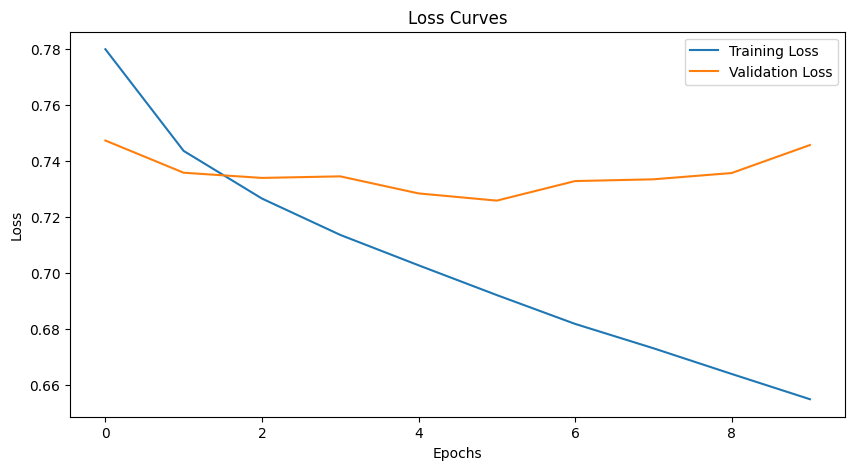

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

In [29]:
# Initialize lists to store true labels and predicted labels for the entire validation set
true_labels = []
predicted_labels = []

# Validation phase
model.eval()
loss = 0.0
with torch.no_grad():
    for images_test, attributes_test in test_loader:
        images_test, attributes_test = images_test.to(device), attributes_test.to(device)
        test_outputs = torch.sigmoid(model(images_test))
        test_loss = criterion(test_outputs, attributes_test.float())
        loss += test_loss.item()
        
        # Convert outputs to binary predictions using a threshold (e.g., 0.5)
        predicted = test_outputs > 0.3
        
        # Convert tensors to numpy arrays
        attributes_test_np = attributes_test.cpu().numpy()
        predicted_np = predicted.cpu().numpy()
        
        # Append true labels and predicted labels to the lists
        true_labels.extend(attributes_test_np)
        predicted_labels.extend(predicted_np)

loss /= len(test_loader)

# Compute confusion matrix
d = classification_report(true_labels, predicted_labels, target_names=attr_100_list, output_dict=True, zero_division=1)
df_metrics = metrics_df(d)
print(loss)

+--------------+-------------+----------+------------+-----------+
| type         |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| weighted avg |     0.26082 |  0.61924 |    0.36397 |     36128 |
| samples avg  |     0.32281 |  0.77885 |    0.32377 |     36128 |
| macro avg    |     0.23662 |  0.55393 |    0.32877 |     36128 |
| micro avg    |     0.25028 |  0.61924 |    0.35648 |     36128 |
+--------------+-------------+----------+------------+-----------+
4.44593102760315


In [17]:
# Initialize lists to store true labels and predicted labels for the entire validation set
true_labels = []
predicted_labels = []

# Validation phase
model.eval()
loss = 0.0
with torch.no_grad():
    for images_test, attributes_test in test_loader:
        images_test, attributes_test = images_test.to(device), attributes_test.to(device)
        test_outputs = torch.sigmoid(model(images_test))
        test_loss = criterion(test_outputs, attributes_test.float())
        loss += test_loss.item()
        
        # Convert outputs to binary predictions using a threshold (e.g., 0.5)
        predicted = test_outputs > 0.5
        
        # Convert tensors to numpy arrays
        attributes_test_np = attributes_test.cpu().numpy()
        predicted_np = predicted.cpu().numpy()
        
        # Append true labels and predicted labels to the lists
        true_labels.extend(attributes_test_np)
        predicted_labels.extend(predicted_np)

loss /= len(test_loader)

# Compute confusion matrix
d = classification_report(true_labels, predicted_labels, target_names=attr_100_list, output_dict=True, zero_division=1)
df_metrics = metrics_df(d)
print(loss)

c:\Users\hecan\AppData\Local\Programs\Python\Python311\Lib\site-packages\timm\models\vision_transformer.py:91: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  x = F.scaled_dot_product_attention(


+--------------+-------------+----------+------------+-----------+
| type         |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| weighted avg |     0.56158 |  0.20383 |    0.26577 |     36128 |
| samples avg  |     0.89984 |  0.5359  |    0.49607 |     36128 |
| macro avg    |     0.54886 |  0.15938 |    0.21697 |     36128 |
| micro avg    |     0.60455 |  0.20383 |    0.30487 |     36128 |
+--------------+-------------+----------+------------+-----------+
4.44593102760315


In [18]:
# Initialize lists to store true labels and predicted labels for the entire validation set
true_labels = []
predicted_labels = []

# Validation phase
model.eval()
loss = 0.0
with torch.no_grad():
    for images_test, attributes_test in test_loader:
        images_test, attributes_test = images_test.to(device), attributes_test.to(device)
        test_outputs = torch.sigmoid(model(images_test))
        test_loss = criterion(test_outputs, attributes_test.float())
        loss += test_loss.item()
        
        # Convert outputs to binary predictions using a threshold (e.g., 0.5)
        predicted = test_outputs > 0.4
        
        # Convert tensors to numpy arrays
        attributes_test_np = attributes_test.cpu().numpy()
        predicted_np = predicted.cpu().numpy()
        
        # Append true labels and predicted labels to the lists
        true_labels.extend(attributes_test_np)
        predicted_labels.extend(predicted_np)

loss /= len(test_loader)

# Compute confusion matrix
d = classification_report(true_labels, predicted_labels, target_names=attr_100_list, output_dict=True, zero_division=1)
df_metrics = metrics_df(d)
print(loss)

+--------------+-------------+----------+------------+-----------+
| type         |   precision |   recall |   f1-score |   support |
|--------------+-------------+----------+------------+-----------|
| weighted avg |     0.40482 |  0.39986 |    0.38413 |     36128 |
| samples avg  |     0.6811  |  0.6504  |    0.47519 |     36128 |
| macro avg    |     0.38257 |  0.33219 |    0.33694 |     36128 |
| micro avg    |     0.42805 |  0.39986 |    0.41348 |     36128 |
+--------------+-------------+----------+------------+-----------+
4.44593102760315
